# Image classification with Keras

Выполнил: студент группы А-14м-16 Мигаль Иван.

Описание:

Решение задачи классификации образов (кошек и собак) с помощью keras (VGG16, Imagenet). 

Для начала подключим необходимые модули и выведем их версии, в том числе версию python3. 
Также выведем абсолютный путь к папке с python3 (для разработчиков).

In [1]:
%matplotlib inline
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras import optimizers
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils import np_utils
import os
import matplotlib
import urllib.request
import http.client
import json
from fabric.api import execute, local, run, lcd, task
from tqdm import tqdm_notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sys
import getpass
import zipfile
import glob

usrname = getpass.getuser()

print('Версия python3:', sys.version)
print('Версия keras:', keras.__version__)
print('Версия matplotlib:', matplotlib.__version__)
print('Версия urlib.request', urllib.request.__version__)
print('Версия numpy', np.__version__)
print('Версия OpenCV:', cv2.__version__)
print('Абсолютный путь к папке python3:', sys.executable)
print('Имя пользователя', usrname)

Using TensorFlow backend.


Версия python3: 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Версия keras: 2.0.9
Версия matplotlib: 1.5.3
Версия urlib.request 3.5
Версия numpy 1.11.1
Версия OpenCV: 3.2.0
Абсолютный путь к папке python3: /home/ivmig/anaconda3/bin/python
Имя пользователя ivmig


Теперь скачаем данные. Это размеченные картинки кошек и собак с соревнования Kaggle. Получить доступ к ним с одноименного сайта проблематично. К счастью, на сайте Майкрософт эти данные тоже есть, поэтому скачивать будем оттуда. Обучение нейросети на практике занимает от одного дня до недели. К счастью, в Keras уже есть предобученная модель, которую можно использовать.

In [2]:
%%time

path_to_data_no_split = os.getcwd() + '/data_no_split/'
path_to_zip_file = path_to_data_no_split + 'cat_dog_images.zip'    

# Создаем директорию, если таковая отсутствует
if not os.path.exists(path_to_data_no_split):
    os.makedirs(path_to_data_no_split)

# Скачивание данных
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
if not os.path.exists(path_to_zip_file):
    urllib.request.urlretrieve(url, path_to_zip_file)

# Распаковка архива
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
if not os.path.exists(path_to_data_no_split+'PetImages/'):
    zip_ref.extractall(path_to_data_no_split)
zip_ref.close()

CPU times: user 332 ms, sys: 364 ms, total: 696 ms
Wall time: 1.92 s


Теперь необходимо проверить картинки на качество: некоторые файлы могу быть "битыми". Для этого определим функцию `check_class_num`. В ней мы проверяем, сколько изображений можно использовать для обучения, сквозной проверки и теста. Заодно и получить список имен файлов, которые можно использовать. Он необходим для поэлементного чтения картинок для обучения, сквозной проверки и теста. Это выгодно, когда мало оперативной памяти.

In [3]:
# Обозначения классов
classes = ["dog", "cat"]
num_classes = len(classes)

# Размерность изображения
img_width, img_height = 224, 224

# Посчитать число небитых картинок
def check_class_num(img_begin=0, img_count=100):
    folders = ["Dog", "Cat"]
    cat_dog_num = {folders[0] : 0, folders[1] : 0}
    cat_dog_list = {folders[0] : [], folders[1] : []}
    
    for fld in folders:
        index = folders.index(fld)
        path = os.path.join(path_to_data_no_split+'PetImages/', fld, '*g')
        files = glob.glob(path)
        i = 0
        
        for fl in tqdm_notebook(files[img_begin:img_begin+img_count]):
            flbase = os.path.basename(fl)
            try:
                img = cv2.imread(fl)
                resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
            except:
                continue
            cat_dog_num[fld] += 1
            cat_dog_list[fld] += [fl]
            
    return cat_dog_num, cat_dog_list

In [4]:
cat_dog_num, cat_dog_list = check_class_num(img_begin=0, img_count=12500)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Мы получили список файлов, которые можно читать и использовать для классификации. Сейчас создадим модель нейронной сети VGG-16 с весами, натреннированными ранее. Далее будем ее использовать для классификации. Однако здесь есть один нюанс, который мы увидим ниже.

In [5]:
model = VGG16(weights='imagenet')

Predicted: ('flat-coated_retriever', 0.8428185)


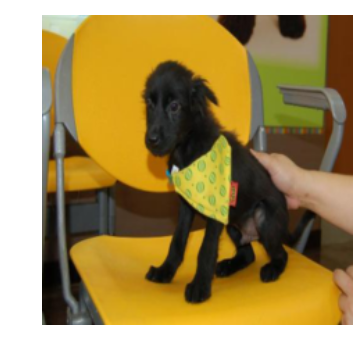

Predicted: ('Chihuahua', 0.38683131)


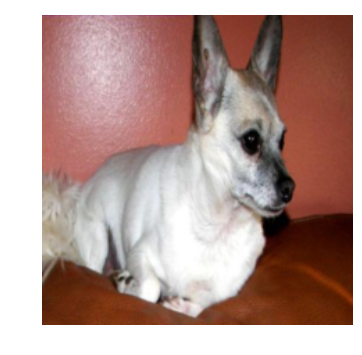

Predicted: ('fire_screen', 0.12055449)


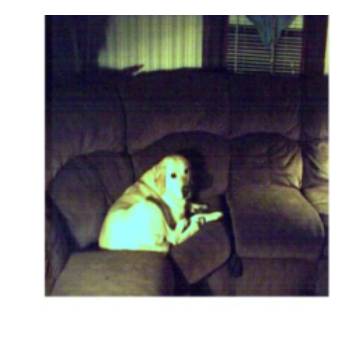

Predicted: ('cocker_spaniel', 0.81966233)


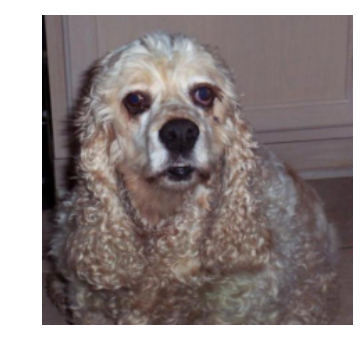

Predicted: ('Ibizan_hound', 0.34209001)


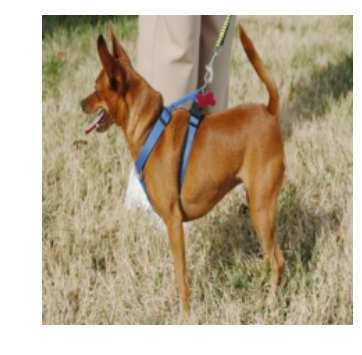

In [6]:
for img_path in cat_dog_list['Dog'][:5]:
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')  # clear x- and y-axes
    print('Predicted:', decode_predictions(preds, top=1)[0][0][1:3])
    plt.show()

Predicted: ('dishwasher', 0.33086279)


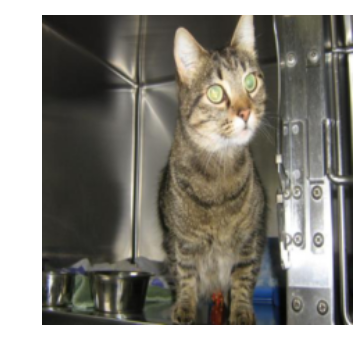

Predicted: ('Siamese_cat', 0.20327559)


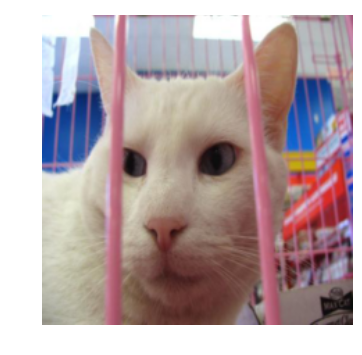

Predicted: ('Persian_cat', 0.91865176)


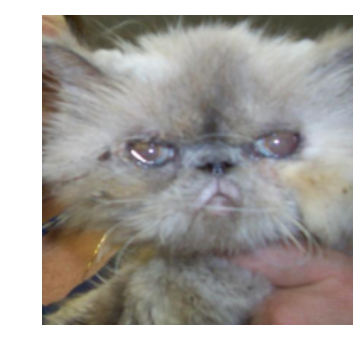

Predicted: ('Eskimo_dog', 0.24725449)


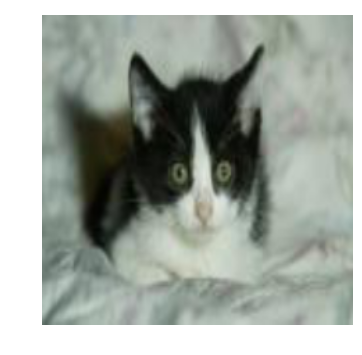

Predicted: ('Egyptian_cat', 0.34559476)


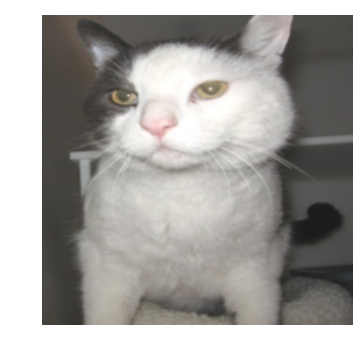

In [7]:
for img_path in cat_dog_list['Cat'][:5]:
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')  # clear x- and y-axes
    print('Predicted:', decode_predictions(preds, top=1)[0][0][1:3])
    plt.show()